# Assignment 11-1: SQL on Everything

## Objectives

In this assignment, you will learn how to use Presto to process data from different data sources within a single query. This reduces the complexity of integrating multiple systems.  
* How to query a table stored in Hive using Presto Hive connector.
* How to join tables from different places using Presto connectors.


## Background

Suppose you are a data scientist working for an airline company. The company has an Amazon EMR cluster with Presto and Hive deployed, and another node with PostgreSQL deployed. The Hive cluster stores a table named `flights`, which contains the flight delay data. The PostgreSQL node stores two tables named `airlines` and `airports`, which provide additional information about airlines and airports for the `flights` table. 

Please check the description of all the tables in the [table_description](./table_description) folder.

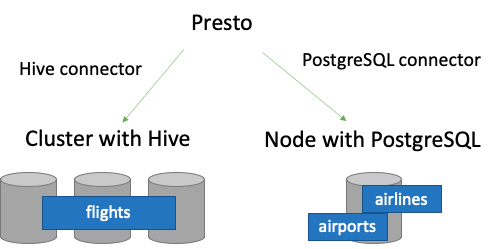


This assignment contains two parts:
- In the first part, you will use Presto to query the `flights` table in Hive. 
- In the second part, you will use Presto to join the `flights` table from Hive with the `airlines` and `airports` tables from PostgreSQL.

For each part, you are given some questions and need to write down an SQL to answer each question. 

**Hint:** The result of each query can be found at the [result](./result) folder.

## Warmup
Please read the Data Sources section in the [documentation](https://prestodb.io/docs/current/overview/concepts.html#data-sources) to learn some basic concepts of Presto.

After you read it, you should know:
* The meaning of `connector`, `catalog`, `schema`, and `table`.
* Every catalog is associated with a specific connector. For example, the `hive` catalog is associated with the Hive connector.
* The fully-qualified table name is `<catalog>.<schema>.<table>`.

## Setup
Now, let us set up the Presto connection and test whether everything works well.
### Step 1. Install pyhive and ipython-sql
[ipython-sql](https://github.com/catherinedevlin/ipython-sql) is a jupyter notebook extension. It allows you to use SQL queries nicely inside jupyter notebooks. To use it, we also need the presto driver from [pyhive](https://github.com/dropbox/PyHive). You can easily install them using pip or Anaconda.
- Open a terminal and type `pip install pyhive ipython-sql` or `conda install -c conda-forge pyhive ipython-sql`.

### Step 2. Download Connection Config

Download the config file `presto.ini` from this [CourSys](https://coursys.sfu.ca/2021sp-cmpt-733-g1/pages/Presto_Config) (must log in to view) and put it in the `conf` folder.

### Step 3. Connect to Presto
Now we connect to Presto. We first load the `ipython-sql` module and the `get_connection_string` function from the `load_config.py` file. Run the cell below:

In [ ]:
from load_config import get_connection_string
%load_ext sql

Next, we load the config file and get the connection string, and then configure `ipython-sql`. Note that we set autolimit to 200, which means that the result fetches at most 200 rows.

In [ ]:
cstr = get_connection_string("conf/presto.ini")
%sql $cstr
%config SqlMagic.autocommit=False
%config SqlMagic.displaycon = False
%config SqlMagic.autolimit = 200

### Step 3. Test Connection
We're ready to issue a query. The cell below shows how to display catalogs in Presto. Run it and see whether everything works:

In [ ]:
%sql SHOW CATALOGS

You should see `hive` and `postgresql` in the catalogs. They represent the Hive and PostgreSQL connectors, respectively. Now, we list the schemas in Hive by issing `SHOW SCHEMAS FROM <CATALOG>`:

In [ ]:
%sql SHOW SCHEMAS FROM hive

You should see the `cmpt733` schema. We list its table:

In [ ]:
%sql SHOW TABLES FROM hive.cmpt733

You should see the `flights` table. As we said before, table is identified by `<catalog>.<schema>.<table>`. You can access the `flights` table directly by `hive.cmpt733.flights`. Finally let us see what contains in `flights`. We show 10 rows of the table and save the result as a pandas dataframe:

In [ ]:
result = %sql SELECT * FROM hive.cmpt733.flights LIMIT 10
df = result.DataFrame()
df

If the SQL is long, you may want to use `%%sql` to run a SQL with multiple lines:

In [ ]:
%%sql 
result << 
SELECT * 
FROM hive.cmpt733.flights 
LIMIT 10

In [ ]:
df = result.DataFrame()
df

## Part 1. Query table in Hive through Presto

Now let us explore the `flights` table and answer some questions. The answer to each question should be **a single SQL query**.



### Q1.1 Which month has the lowest average departure delay? Output the month and the average delay.

In [ ]:
%%sql
#Write a single SQL query

### Q1.2  What is the most frequent cancellation reason for airlines that have been canceled more than 5000 times? Output the cancellation reason and its frequency. Note that the empty string in the *cancellation_reason* column does not count.

In [ ]:
%%sql
#Write a single SQL query

## Part 2: Query tables from different sources
In `flights` table, the *airline_code*, *origin_airport_code* and *destination_airport_code* columns are both IATA code. We want to know more information about them such as the name of airline and airport, and the location of airport. To achieve this goal, we will join `flights` with another two tables, `airlines` and `airports`, which are stored in PostgreSQL.

PostgreSQL connector uses `postgresql` catalog. The `airlines` and `airports` table are both in the `postgresql` catalog and `cmpt733` schema.

To test, run the following two cells to see what the `airlines` and `airports` tables contain:

In [ ]:
%sql SELECT * FROM postgresql.cmpt733.airlines

In [ ]:
%sql SELECT * FROM postgresql.cmpt733.airports

In Presto, joining tables from different sources is pretty easy. It provides a unified view to manage different data sources by using connectors. You can process them like they are in the same database. For example, in the following, we join the `airline_code` column in `flights` with `iata_code` in the `airlines` table:

In [ ]:
%%sql  
SELECT f.*, L.airline
FROM hive.cmpt733.flights as F
JOIN postgresql.cmpt733.airlines as L ON F.airline_code = L.iata_code
LIMIT 10

Next, let us use the `flights` table as well as the `airlines` and `airports` tables to answer the following questions. The answer to each question should be **a single SQL query**.


### Q2.1  What is the average arrival delay for each airline on weekends (Satursday and Sunday)? Output the names of airlines with the average delays. 

In [ ]:
%%sql
#Write a single SQL query

### Q2.2 Compute the average cancellation rate of each day of week (Monday - Sunday) for the flights from Columbia to Chicago in February. Output the average cancellation rates for Monday - Sunday.

In [ ]:
%%sql
#Write a single SQL query

### Q2.3 How many unique flights (flight number) are from New York to Houston by United Air Lines Inc. on each day of week (Monday - Sunday)? Output the number of unique flights for Monday - Sunday.

In [ ]:
%%sql 
#Write a single SQL query

## Reading (Optional)

* Sethi, Raghav, et al. "[Presto: SQL on Everything](https://research.fb.com/wp-content/uploads/2019/03/Presto-SQL-on-Everything.pdf)" 2019 IEEE 35th International Conference on Data Engineering (ICDE). IEEE, 2019.
* [OpenLookEng](https://openlookeng.io/) is an open-source tool built on top of Presto, released by Huawei Technologies Co., Ltd. It improves Presto's performance with several optimizations, such as Heuristic Index, Adaptive Dynamic Filter, Cross Region Connector, .... You can try it out at https://tryme.openlookeng.io/.



## Submission

Complete the code in A11-1.ipynb, and submit it to the CourSys activity Assignment 11.